In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
data_dir = 'data'
image_paths = []
labels = []
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        if img_file.endswith(('.png', '.jpg', '.jpeg', '.webp')):
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(class_to_idx[class_name])

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG16 requires 224x224 images
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # ImageNet normalization
])

In [6]:
train_dataset = CustomImageDataset(train_paths, train_labels, transform=transform)
test_dataset = CustomImageDataset(test_paths, test_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model = torchvision.models.vgg16(pretrained=True)

c:\Users\Swasthik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Swasthik\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Swasthik/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:44<00:00, 12.4MB/s] 


In [9]:
model.classifier[6] = nn.Linear(4096, len(class_names))  # Replace the last layer for 4 classes
model = model.to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [11]:
num_epochs = 20
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/20, Loss: 1.3530
Epoch 2/20, Loss: 1.2191
Epoch 3/20, Loss: 1.1476
Epoch 4/20, Loss: 1.0127
Epoch 5/20, Loss: 0.9356
Epoch 6/20, Loss: 0.7609
Epoch 7/20, Loss: 0.6932
Epoch 8/20, Loss: 0.4795
Epoch 9/20, Loss: 0.4089
Epoch 10/20, Loss: 0.3671
Epoch 11/20, Loss: 0.3373
Epoch 12/20, Loss: 0.3042
Epoch 13/20, Loss: 0.2740
Epoch 14/20, Loss: 0.2427
Epoch 15/20, Loss: 0.2047
Epoch 16/20, Loss: 0.1960
Epoch 17/20, Loss: 0.1865
Epoch 18/20, Loss: 0.1880
Epoch 19/20, Loss: 0.1754
Epoch 20/20, Loss: 0.1733


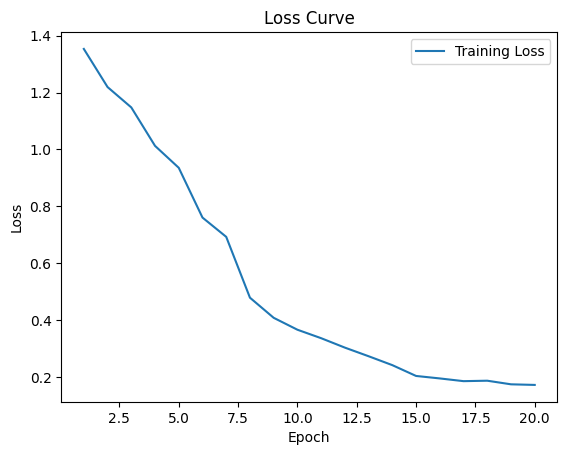

In [12]:
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

In [13]:
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.86


In [14]:
print(classification_report(all_labels, all_preds, target_names=class_names))

                 precision    recall  f1-score   support

          drive       0.83      0.88      0.85       245
legglance-flick       0.91      0.83      0.87       224
       pullshot       0.84      0.86      0.85       252
          sweep       0.86      0.86      0.86       224

       accuracy                           0.86       945
      macro avg       0.86      0.86      0.86       945
   weighted avg       0.86      0.86      0.86       945



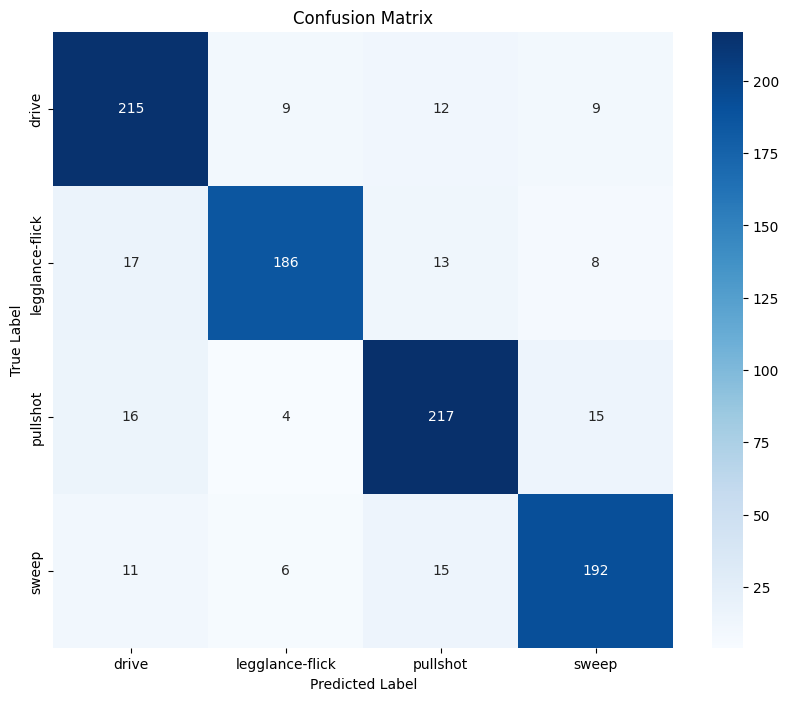

In [15]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()